In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import scipy.fftpack
import scipy.signal

# Set rcParams to customize tick labels and spines
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['legend.loc'] = 'upper right'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams["figure.autolayout"] = True


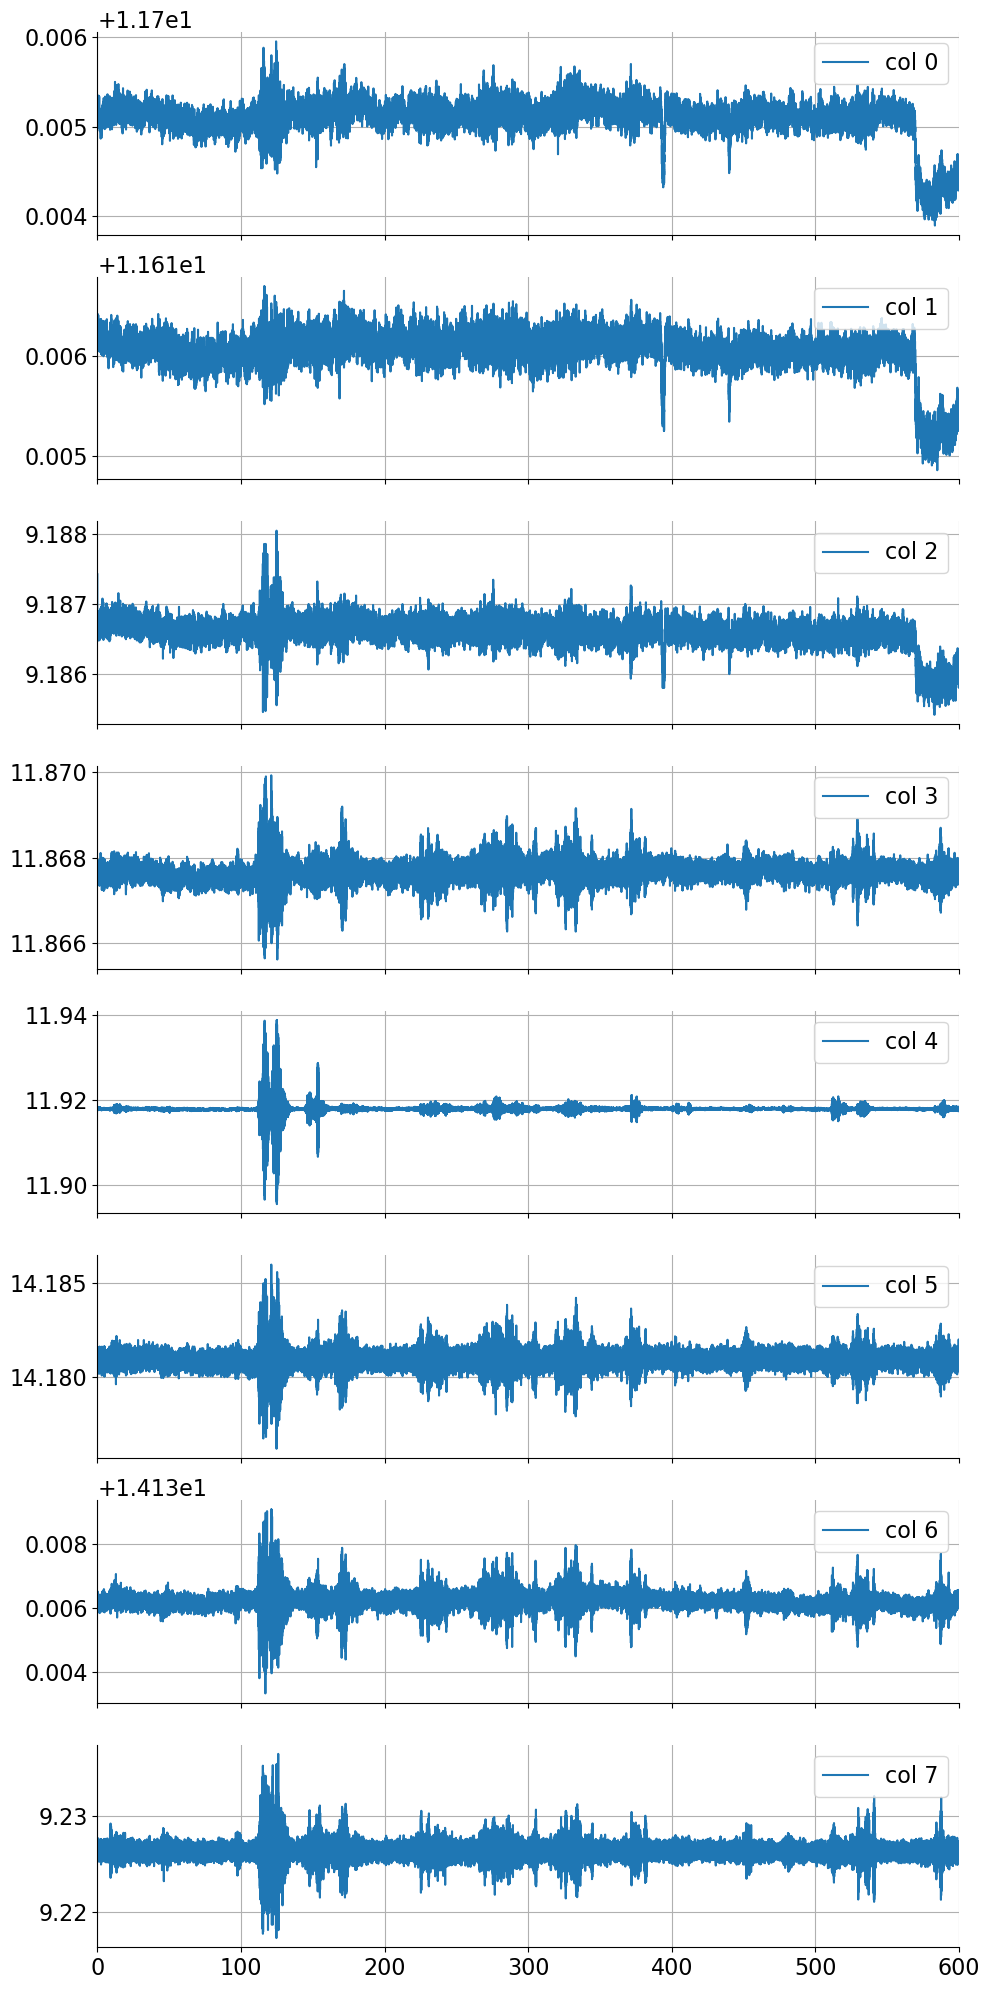

In [10]:
# Load the datas
data_23_01 = np.loadtxt("Lello/Jul23/data_2023_07_10_040019_0.csv", delimiter=";")

# Extract time and sensor data
time = data_23_01[:, 0]
sensor_data = data_23_01[:, 1:]

# Plot the datas
fig, ax = plt.subplots(len(sensor_data[0]), 1, sharex=True, figsize=(10, 20))
for i in range(8):
    ax[i].plot(time, sensor_data[:, i], label=f"col {i}")
    ax[i].legend()
    ax[i].set_xlim(0, 600)
plt.show()


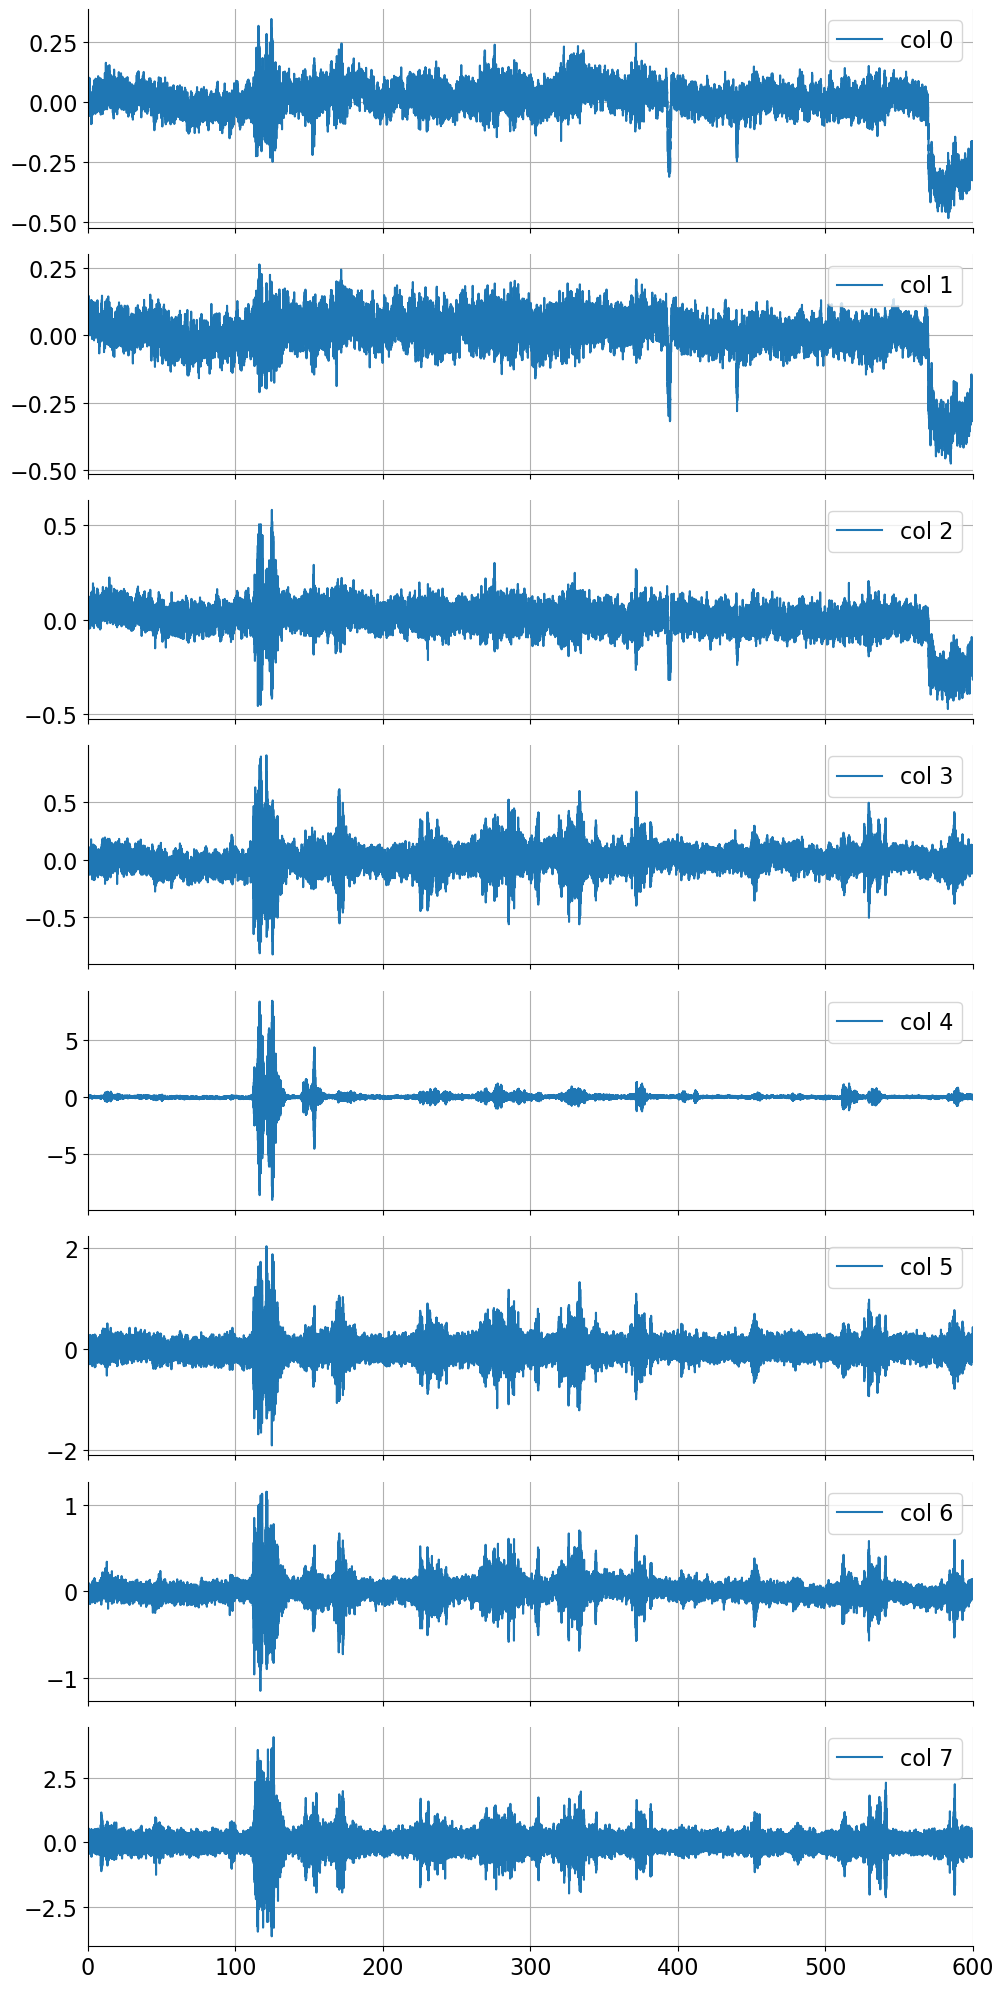

In [11]:
# Parameters
n_samples, n_sensors = sensor_data.shape

# Get the Discrete Fourier Transform (DFT) sample frequencies
sampling_dt = np.mean(np.diff(time)) # s
frequencies = np.fft.rfftfreq(n_samples, d=sampling_dt)

# Subtract the mean to remove the DC component
sensor_data_detrended = sensor_data - np.mean(sensor_data, axis=0)

# Scale the data, convert electrical signal (ampers) to "10-3 g" (i.e., mg)
factors = np.array([0.4035*1000, 0.4023*1000, 0.4023*1000, 0.4023*1000, 0.4015*1000, 0.4014*1000, 0.4007*1000, 0.4016*1000])
sensor_data_detrended = sensor_data_detrended * factors

# Plot the scaled datas without the DC component
fig, ax = plt.subplots(len(sensor_data_detrended[0]), 1, sharex=True, figsize=(10, 20))
for i in range(8):
    ax[i].plot(time, sensor_data_detrended[:, i], label=f"col {i}")
    ax[i].legend()
    ax[i].set_xlim(0, 600)
plt.show()

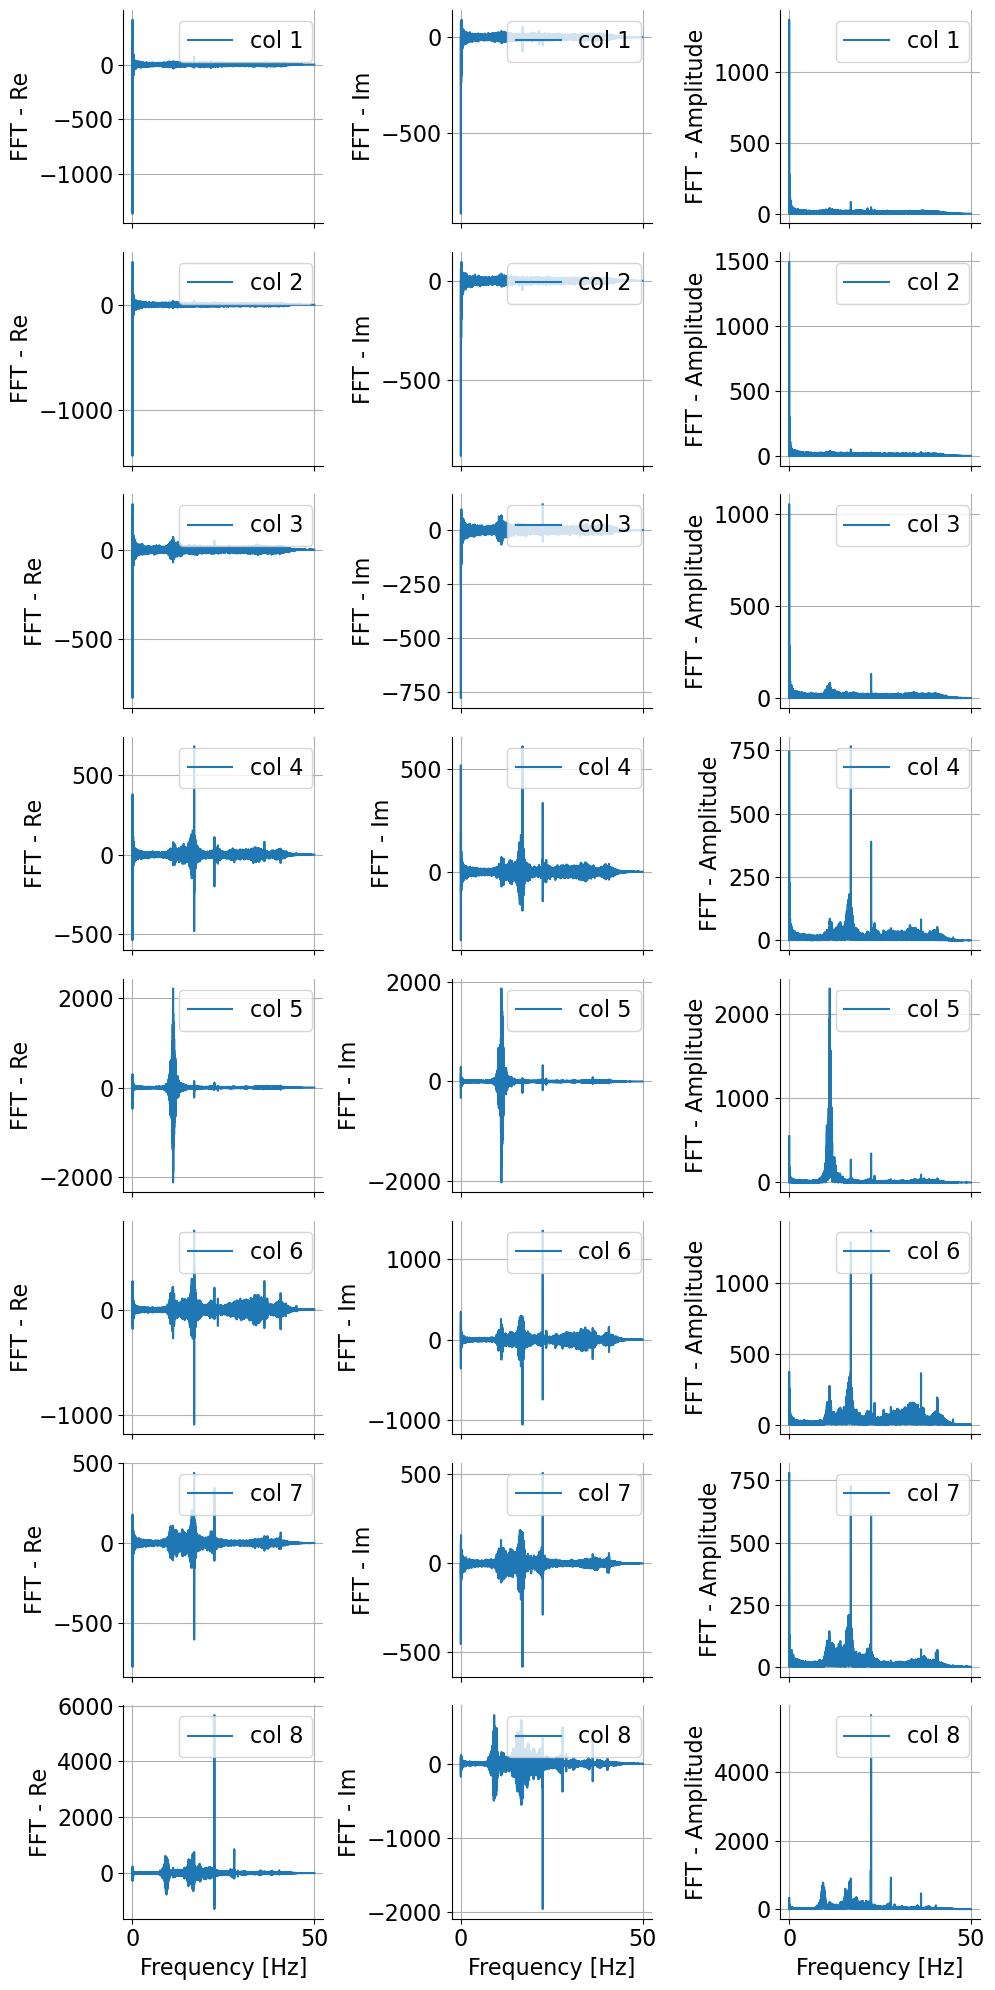

In [12]:
# Convert to frequency domain by FFT
data_fft = np.fft.rfft(sensor_data_detrended, axis=0)

# Plot the FFT
fig, ax = plt.subplots(len(sensor_data_detrended[0]), 3, sharex=True, figsize=(10, 20))
for i in range(8):
    ax[i, 0].plot(frequencies[:], np.real(data_fft[:, i]), label=f"col {i+1}")
    ax[i, 0].legend()
    ax[i, 0].set_ylabel("FFT - Re")
    ax[i, 1].plot(frequencies[:], np.imag(data_fft[:, i]), label=f"col {i+1}")
    ax[i, 1].legend()
    ax[i, 1].set_ylabel("FFT - Im")
    ax[i, 2].plot(frequencies[:], np.abs(data_fft[:, i]), label=f"col {i+1}")
    ax[i, 2].legend()
    ax[i, 2].set_ylabel("FFT - Amplitude")
ax[-1, 0].set_xlabel("Frequency [Hz]")
ax[-1, 1].set_xlabel("Frequency [Hz]")
ax[-1, 2].set_xlabel("Frequency [Hz]")
plt.show()

In [13]:
# Calculate Power Spectral Density (PSD) matrix
psd_matrix = np.zeros((len(frequencies), n_sensors, n_sensors), dtype=complex)
for i in range(len(frequencies)):
    psd_matrix[i] = np.outer(data_fft[i], np.conjugate(data_fft[i])) / n_samples
print(psd_matrix.shape)

# plot PSD matrix
# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# for i in range(8):
#     for j in range(8):
#         ax.plot(frequencies, np.abs(psd_matrix[:, i, j]), label=f"col {i} vs col {j}")
# ax.set_xlabel("Frequency [Hz]")
# ax.set_ylabel("PSD")
# ax.legend()
# plt.show()

(30001, 8, 8)


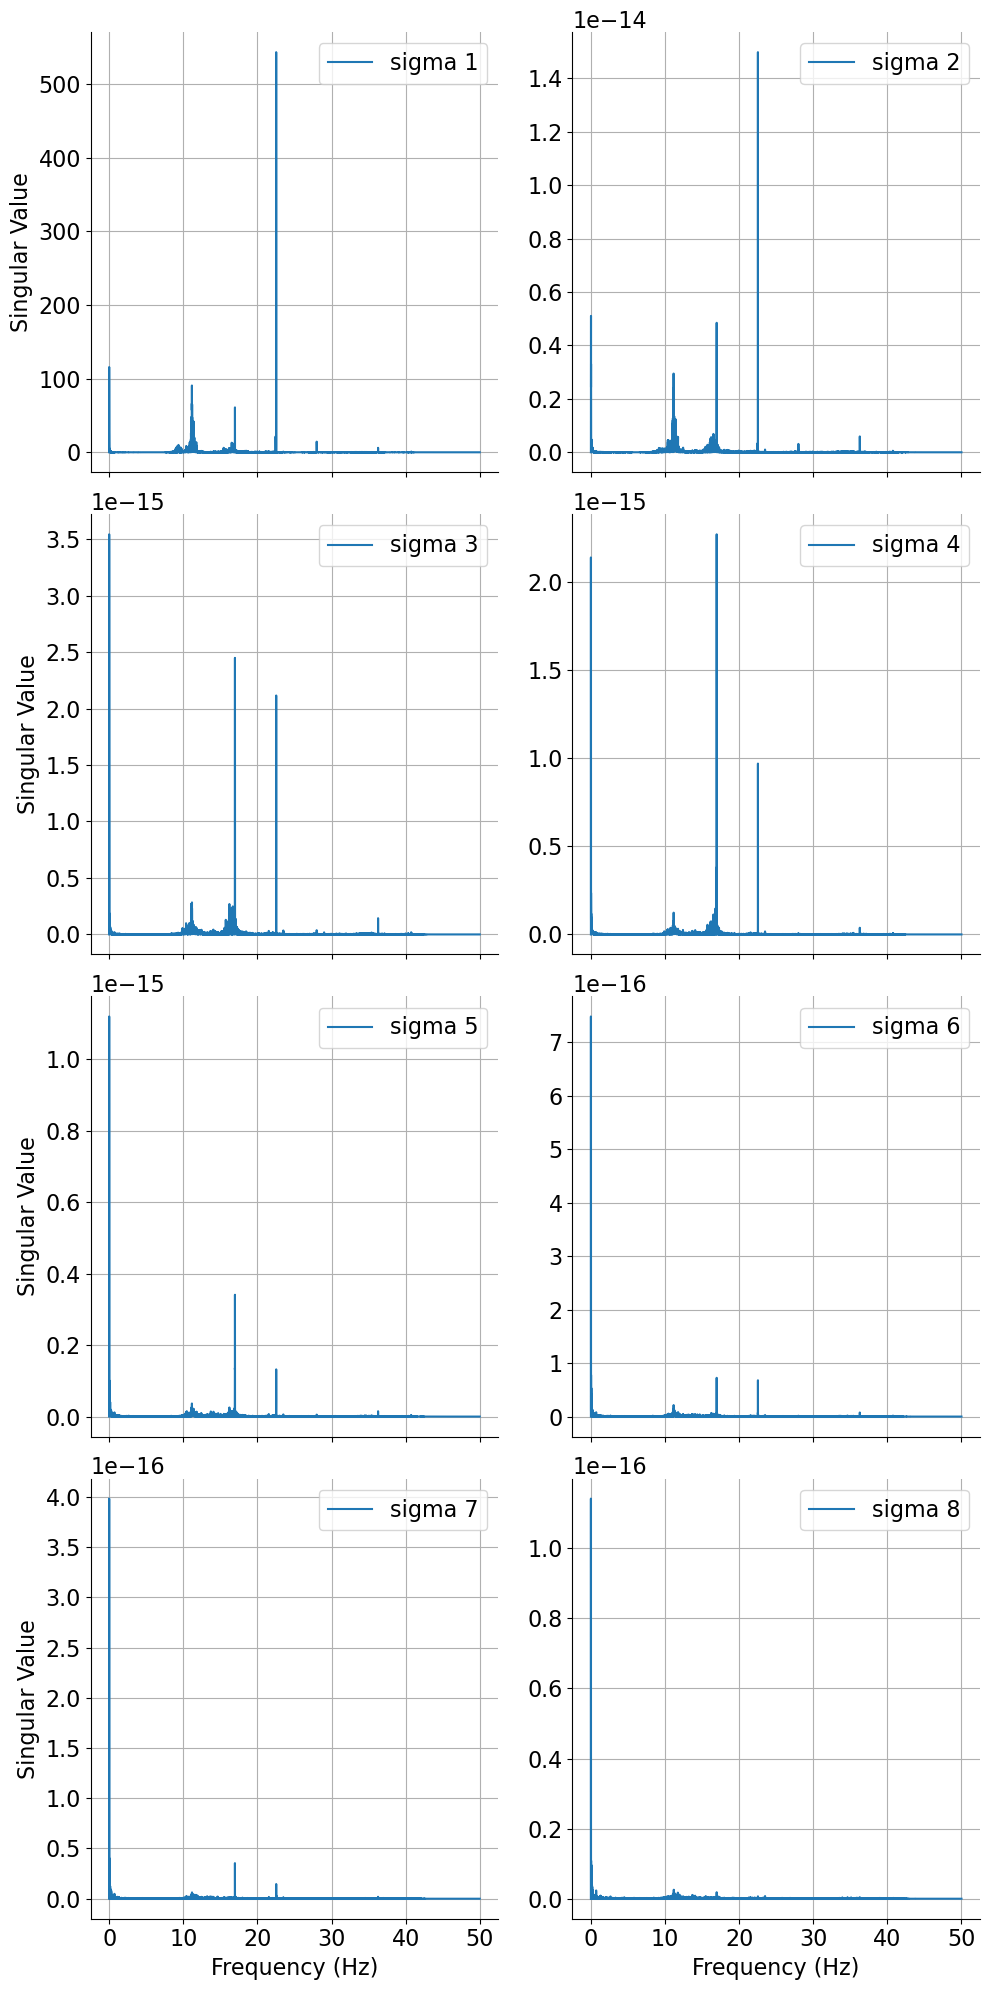

In [14]:
# Perform Singular Value Decomposition (SVD) on the PSD matrix
U, S, V = np.linalg.svd(psd_matrix, full_matrices=False)

# Plotting the singular values
if len(S[0]) != 8 : print("ERROR")
fig, ax = plt.subplots(4, 2, sharex=True, figsize=(10, 20))
for i in range(n_sensors):
    ax[i//2, i%2].plot(frequencies, S[:, i], label=f'sigma {i+1}')
    if i%2 == 0: ax[i//2, i%2].set_ylabel('Singular Value')
    ax[i//2, i%2].legend()
ax[-1, 0].set_xlabel('Frequency (Hz)')
ax[-1, 1].set_xlabel('Frequency (Hz)')

plt.show()
fig.savefig("SVD_sigma_all.pdf", format='pdf', bbox_inches='tight')

In [8]:
# Peak picking
singular_value_peaks = np.argmax(S, axis=0) # MODIFY TO TAKE INTO ACCOUNT AVERAGE SINGULAR VALUE

# Extract mode shapes (using the significant singular value's corresponding singular vector)
# mode_shapes = U[singular_value_peaks, :, 0]

# Example of identifying a specific mode
mode_frequency = frequencies[singular_value_peaks[0]]
print(f"Identified mode frequency: {mode_frequency} Hz")

Identified mode frequency: 22.535 Hz
